In [1]:
#default_exp replan

In [1]:
#hide
from nbdev.showdoc import *

#%load_ext autoreload
#%autoreload 2

import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


## Imports

In [378]:
#export
import warnings

import numpy as np

from sklearn.utils.validation import check_is_fitted, check_array
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer, normalize
from sklearn.cluster import KMeans

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.utils._encode import _unique


from scipy import sparse
try:
    from sparse_dot_topn import awesome_cossim_topn
except Exception as e:
    warn(f'could not load sparse_dot_topn: {e}')

In [379]:
import pandas as pd
from sklearn.linear_model import SGDRegressor, SGDClassifier, LinearRegression, LogisticRegression
from sknetwork.clustering import KMeans as KMeansNetwork
from sknetwork.clustering import Louvain

## Util Functions

In [380]:
#export

def sparse_dot_product(
    A,
    B,
    ntop = 1,
    lower_bound=0,
    use_threads=False,
    n_jobs=1,
    return_best_ntop=False,
    test_nnz_max=-1,
):
    
    '''
    flexible dot product function to work with or without sparse_dot_topn. In the absence of sparse_dot_topn, naive numpy dot product will be performed
    
    sparse_dot_topn.awesome_cossim_topn Docs:
    
    This function will return a matrix C in CSR format, where
    C = [sorted top n results > lower_bound for each row of A * B].
    If return_best_ntop=True then best_ntop
    (the true maximum number of elements > lower_bound per row of A * B)
    will also be returned in a tuple together with C as (C, best_ntop).

    Input:
        A and B: two CSR matrices
        ntop: top n results
        lower_bound: a threshold that the element of A*B must be greater than
        use_threads: use multi-thread or not
        n_jobs: number of thread, must be >= 1
        return_best_ntop: (default: False) if True, will return best_ntop together 
                          with C as a tuple: (C, best_ntop)

    Output:
        C: result matrix (returned alone, if return_best_ntop=False)
        best_ntop: The true maximum number of elements > lower_bound per row of 
                   A * B returned together with C as a tuple: (C, best_ntop). It is 
                   returned only if return_best_ntop=True.

    N.B. if A and B are not in CSR format, they will be converted to CSR
    '''
    
    A = sparse.csr_matrix(A)
    B = sparse.csr_matrix(B)
    if 'awesome_cossim_topn' in globals():
        dot = awesome_cossim_topn(
            A = A,
            B = B,
            ntop = ntop,
            lower_bound=lower_bound,
            use_threads=use_threads,
            n_jobs=n_jobs,
            return_best_ntop=return_best_ntop,
            test_nnz_max=test_nnz_max,
        )
    else:
        warn('sparse_dot_topn is not installed, this may cause performance issues in dot product calculations')
        dot = A@B
    
    return dot

## RobustKBinsDiscretizer

In [381]:
#export
class RobustKBinsDiscretizer(KBinsDiscretizer):
    
    def __init__(
        self,
        n_bins=5,
        *,
        encode='onehot',
        strategy='quantile',
        dtype=None,
        handle_nan = 'handle', #error, handle, ignore        
    ):        
        self.encode = encode
        self.strategy = strategy
        self.dtype = dtype
        self.handle_nan = handle_nan      
        super().__init__(n_bins = n_bins,encode = encode,strategy = strategy,dtype = dtype)
        return
    
    
    def fit(self, X, y=None):
        """
        Fit the estimator.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to be discretized.
        y : None
            Ignored. This parameter exists only for compatibility with
            :class:`~sklearn.pipeline.Pipeline`.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        valid_handling = ["handle","error","ignore"]
        if not self.handle_nan in valid_handling:
            raise ValueError(f'handle_nan should be one of {valid_handling}, got {self.handle_nan}')
                        
        #make it robust to NaNs
        if self.handle_nan in ('handle','ignore'):
            X = self._validate_data(X, dtype="numeric", force_all_finite = "allow-nan")
        else:
            X = self._validate_data(X, dtype="numeric")
            
        supported_dtype = (np.float64, np.float32)
        if self.dtype in supported_dtype:
            output_dtype = self.dtype
        elif self.dtype is None:
            output_dtype = X.dtype
        else:
            raise ValueError(
                "Valid options for 'dtype' are "
                f"{supported_dtype + (None,)}. Got dtype={self.dtype} "
                " instead."
            )

        valid_encode = ("onehot", "onehot-dense", "ordinal")
        if self.encode not in valid_encode:
            raise ValueError(
                "Valid options for 'encode' are {}. Got encode={!r} instead.".format(
                    valid_encode, self.encode
                )
            )
        valid_strategy = ("uniform", "quantile", "kmeans")
        if self.strategy not in valid_strategy:
            raise ValueError(
                "Valid options for 'strategy' are {}. "
                "Got strategy={!r} instead.".format(valid_strategy, self.strategy)
            )

        n_features = X.shape[1]
        n_bins = self._validate_n_bins(n_features)

        bin_edges = np.zeros(n_features, dtype=object)
        for jj in range(n_features):
            column = X[:, jj]
            #make it Robust to NaNs excluding them from fit
            if self.handle_nan in ('handle','ignore'):
                column = column[~np.isnan(column.flatten())]
            else:
                column = column
            
            col_min, col_max = column.min(), column.max()

            if col_min == col_max:
                warnings.warn(
                    "Feature %d is constant and will be replaced with 0." % jj
                )
                n_bins[jj] = 1
                bin_edges[jj] = np.array([-np.inf, np.inf])
                continue

            if self.strategy == "uniform":
                bin_edges[jj] = np.linspace(col_min, col_max, n_bins[jj] + 1)

            elif self.strategy == "quantile":
                quantiles = np.linspace(0, 100, n_bins[jj] + 1)
                bin_edges[jj] = np.asarray(np.percentile(column, quantiles))

            elif self.strategy == "kmeans":
                #from ..cluster import KMeans  # fixes import loops

                # Deterministic initialization with uniform spacing
                uniform_edges = np.linspace(col_min, col_max, n_bins[jj] + 1)
                init = (uniform_edges[1:] + uniform_edges[:-1])[:, None] * 0.5

                # 1D k-means procedure
                km = KMeans(
                    n_clusters=n_bins[jj], init=init, n_init=1, algorithm="full"
                )
                centers = km.fit(column[:, None]).cluster_centers_[:, 0]
                # Must sort, centers may be unsorted even with sorted init
                centers.sort()
                bin_edges[jj] = (centers[1:] + centers[:-1]) * 0.5
                bin_edges[jj] = np.r_[col_min, bin_edges[jj], col_max]

            # Remove bins whose width are too small (i.e., <= 1e-8)
            if self.strategy in ("quantile", "kmeans"):
                mask = np.ediff1d(bin_edges[jj], to_begin=np.inf) > 1e-8
                bin_edges[jj] = bin_edges[jj][mask]
                if len(bin_edges[jj]) - 1 != n_bins[jj]:
                    warnings.warn(
                        "Bins whose width are too small (i.e., <= "
                        "1e-8) in feature %d are removed. Consider "
                        "decreasing the number of bins." % jj
                    )
                    n_bins[jj] = len(bin_edges[jj]) - 1

        self.bin_edges_ = bin_edges
        self.n_bins_ = n_bins
        #add one bin if create_nan_bin is True        
        if self.handle_nan == 'handle':
            self.n_bins_ += 1
            
        if "onehot" in self.encode:
            if self.handle_nan == 'handle':
                categories = [np.arange(-1,i-1) for i in self.n_bins_]
            elif self.handle_nan == 'ignore':
                categories = [np.arange(i) for i in self.n_bins_]
            else:
                categories = [np.arange(i) for i in self.n_bins_]
            
            self._encoder = OneHotEncoder(
                categories=categories,
                sparse=self.encode == "onehot",
                dtype=output_dtype,
                handle_unknown = "ignore" if self.handle_nan in ('ignore','handle') else "error"
            )
            # Fit the OneHotEncoder with toy datasets
            # so that it's ready for use after the KBinsDiscretizer is fitted
            self._encoder.fit(np.zeros((1, len(self.n_bins_))))

        return self
    
    def transform(self, X):
        """
        Discretize the data.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to be discretized.
        Returns
        -------
        Xt : {ndarray, sparse matrix}, dtype={np.float32, np.float64}
            Data in the binned space. Will be a sparse matrix if
            `self.encode='onehot'` and ndarray otherwise.
        """
        check_is_fitted(self)

        # check input and attribute dtypes
        dtype = (np.float64, np.float32) if self.dtype is None else self.dtype
        if self.handle_nan in ('handle','ignore'):
            Xt = self._validate_data(X, copy=True, dtype=dtype, reset=False, force_all_finite = 'allow-nan')
        else:
            Xt = self._validate_data(X, copy=True, dtype=dtype, reset=False)
        

        bin_edges = self.bin_edges_
        if self.handle_nan in ('handle','ignore'):
            for jj in range(Xt.shape[1]):
                #create empty array of same shape to populate with nans
                Xt_temp = np.empty(Xt[:,jj].shape)
                Xt_nanmsk = np.isnan(Xt[:,jj].flatten())
                column = Xt[:,jj][~Xt_nanmsk]
                # Values which are close to a bin edge are susceptible to numeric
                # instability. Add eps to X so these values are binned correctly
                # with respect to their decimal truncation. See documentation of
                # numpy.isclose for an explanation of ``rtol`` and ``atol``.
                rtol = 1.0e-5
                atol = 1.0e-8
                eps = atol + rtol * np.abs(column)
                column = np.digitize(column + eps, bin_edges[jj][1:])
                if self.handle_nan == 'handle':
                    #clip up to self.n_bins_ - 2, since theres 1 bin for NaNs
                    np.clip(column, 0, self.n_bins_[jj] - 2, out=column)
                    #create NaN Category                
                    Xt_temp[Xt_nanmsk] = -1
                else:                    
                    np.clip(column, 0, self.n_bins_[jj] -1, out=column)
                    #create NaN Category                
                    Xt_temp[Xt_nanmsk] = -1
                                
                #fill template where there are no NaNs
                Xt_temp[~Xt_nanmsk] = column                
                Xt[:, jj] = Xt_temp                        
                
        else:
            for jj in range(Xt.shape[1]):
                # Values which are close to a bin edge are susceptible to numeric
                # instability. Add eps to X so these values are binned correctly
                # with respect to their decimal truncation. See documentation of
                # numpy.isclose for an explanation of ``rtol`` and ``atol``.
                rtol = 1.0e-5
                atol = 1.0e-8
                eps = atol + rtol * np.abs(Xt[:, jj])
                Xt[:, jj] = np.digitize(Xt[:, jj] + eps, bin_edges[jj][1:])            
                
            #clip up to self.n_bins_ - 1 (zero to self.n_bins_ - 1)
            np.clip(Xt, 0, self.n_bins_ - 1, out=Xt)

        if self.encode == "ordinal":
            return Xt

        dtype_init = None
        if "onehot" in self.encode:
            dtype_init = self._encoder.dtype
            self._encoder.dtype = Xt.dtype
        try:
            Xt_enc = self._encoder.transform(Xt)
        finally:
            # revert the initial dtype to avoid modifying self.
            self._encoder.dtype = dtype_init
        return Xt_enc

    def inverse_transform(self, Xt):
        """
        Transform discretized data back to original feature space.
        Note that this function does not regenerate the original data
        due to discretization rounding.
        Parameters
        ----------
        Xt : array-like of shape (n_samples, n_features)
            Transformed data in the binned space.
        Returns
        -------
        Xinv : ndarray, dtype={np.float32, np.float64}
            Data in the original feature space.
        """
        check_is_fitted(self)

        if "onehot" in self.encode:
            Xt = self._encoder.inverse_transform(Xt)            

        Xinv = check_array(Xt, copy=True, dtype=(np.float64, np.float32), force_all_finite='allow-nan')
        
        if self.handle_nan in ('handle','ignore'):            
            xinv_nanmsk = (Xinv == - 1) | np.isnan(Xinv)
        elif self.handle_nan == 'ignore':
            xinv_nanmsk = np.isnan(Xinv)
        else:
            xinv_nanmsk = None
        
        n_features = self.n_bins_.shape[0]
        if Xinv.shape[1] != n_features:
            raise ValueError(
                "Incorrect number of features. Expecting {}, received {}.".format(
                    n_features, Xinv.shape[1]
                )
            )

        for jj in range(n_features):            
            bin_edges = self.bin_edges_[jj]
            bin_centers = (bin_edges[1:] + bin_edges[:-1]) * 0.5
            if self.handle_nan in ('handle', 'ignore'):
                nanmsk = xinv_nanmsk[:, jj].flatten()
                Xinv[~nanmsk, jj] = bin_centers[np.int_(Xinv[~nanmsk, jj])]
                Xinv[nanmsk, jj] = np.nan
            else:
                Xinv[:, jj] = bin_centers[np.int_(Xinv[:, jj])]

        return Xinv    

In [382]:
X = np.random.randint(10,100+10,(10000,2)).astype(float)
X = pd.DataFrame(X)
X.iloc[np.random.choice(np.arange(X.shape[0]), size = 500, replace = False)] = np.nan
#X[:,1] = np.random.randn(1000,)

X_test = np.random.randint(10,100+10,(1000,2)).astype(float)
X_test = pd.DataFrame(X_test)
X_test.iloc[np.random.choice(np.arange(X_test.shape[0]), size = 500, replace = False)] = np.nan


In [383]:
rob = RobustKBinsDiscretizer(
    5,
    strategy = 'kmeans',
    encode = 'ordinal',
    handle_nan = 'handle',
)
disc = rob.fit(X).transform(X_test)

In [384]:
#rob._encoder.inverse_transform(disc)
rob.inverse_transform(disc)#, X_test

array([[        nan,         nan],
       [79.49113256, 99.22869397],
       [39.48704772, 59.39752785],
       ...,
       [59.49644303, 79.45290519],
       [        nan,         nan],
       [39.48704772, 19.67605268]])

## RobustOneHotEncoder

In [385]:
#export
class RobustOneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(
        self,
        categories = 'auto',
        dtype=np.float64,
        handle_unknown = 'error',# for one hot {'error', 'ignore','handle'}
        drop=None,
        sparse=True,
        nan_value = np.nan, #could be "nan" (Str) for example
        handle_nan = 'handle', #error, handle, ignore        
    ):
        '''
        A robust one hot encoder. Always return the same amount of nonzero value sin each transformed row.
        Has columns for unknown values
        '''
        
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown
        self.drop = drop
        self.sparse = sparse
        self.nan_value = nan_value
        self.handle_nan = handle_nan
        return
                    
    def _nan_msk(self, X):
        """
        check NaNs in special cases like 'O' type arrays
        """
        
        
        if self.nan_value in (np.nan,):
            if X.dtype == 'O':
                nanmsk_ = X == 'nan' #'nan' that are not proper NaNs
                nanmsk = X.astype(str) == 'nan' #proper and not propper NaNs
                #exclude values that had "nan" instead of np.nan
                #if want to count them as valid NaNs, perform transformation upstream
                nanmsk = nanmsk & (~nanmsk_)
            else:
                nanmsk = np.isnan(X)
        else:
            nanmsk = (X == self.nan_value)
        
        return nanmsk
    
    def _check_nan_cols(self, X):
        '''
        returns cols with corresponding with self.nan_value
        '''        
        nanmsk = self._nan_msk(X)
        cols_w_nans = np.nonzero(nanmsk.any(0))[0]
        return cols_w_nans        
        
    def _infer_categories(self, X):
        
        categories = []
        for jj in range(X.shape[1]):            
            
            if self.handle_nan in ('handle','ignore'):
                #if nan handling, create a NaN msk
                if self.nan_value in (np.nan,):
                    if X[:, jj].dtype == 'O':
                        nanmsk_ = X[:, jj] == 'nan' #'nan' that are not proper NaNs
                        nanmsk = X[:, jj].astype(str) == 'nan' #proper and not propper NaNs
                        #exclude values that had "nan" instead of np.nan
                        #if want to count them as valid NaNs, perform transformation upstream
                        nanmsk = nanmsk & (~nanmsk_)
                    else:
                        nanmsk = np.isnan(X[:, jj])
                    
                else:
                    nanmsk = (X[:, jj] == self.nan_value)
                
                #if want to create nan dummies, should include nans do categories
                #even if not found during train
                if self.handle_nan == 'handle':
                    unq = _unique(X[:,jj])
                    
                    if (nanmsk.sum() == 0)  and (self.handle_unknown == 'handle'):
                        #append nan class even if there are no nans in traning
                        #unknown nans are treatted diffrently from unknown non-nans
                        unq = np.append(unq, self.nan_value)
                                            
                    categories.append(unq)
                
                #if nans are to be ignored in dummies, exclude nans in training set
                else:                                        
                    #exclude NaNs and append only other categories
                    #case where handle_nan is set to ignore or create_nan_dummy is set to False
                    categories.append(_unique(X[~nanmsk,jj]))
            
            #if not handle_nan, appends regular unique categories
            #nan checking is assumed to be performed upstream
            else:
                categories.append(_unique(X[:,jj]))
            
        return categories            
            
    def fit(self, X, y = None, **kwawrgs):                                
        
        #check array
        X = check_array(X, dtype = None, force_all_finite = 'allow-nan')
        #check nans
        if self.handle_nan == 'error':
            nancols = self._check_nan_cols(X).tolist()
            if nancols:
                raise ValueError(f'Columns {[i for i in nancols]} has NaN Values set to {self.nan_value} ({type(self.nan_value)})')        
        
        ordinal_handle = 'use_encoded_value' if self.handle_unknown in ('handle','ignore') else 'error'
        if self.categories == 'auto':
            ordinal_categories = self._infer_categories(X)
        else:
            ordinal_categories =self.categories
            
        self.ordinalencoder_ = OrdinalEncoder(
            handle_unknown = ordinal_handle,
            unknown_value = -1 if ordinal_handle == 'use_encoded_value' else None,
            categories = ordinal_categories,
            dtype = self.dtype,            
        ).fit(X)        
        
        X = self.ordinalencoder_.transform(X)
        
        
        if self.handle_unknown in ('ignore', 'error'):
            #ordinal encoder returns a category called nan instead of ordinal index when nans are passed in input
            onehot_categories = []
            for cats in self.ordinalencoder_.categories_:
                if self._nan_msk(cats).sum() == 0:
                    onehot_categories.append(np.arange(0, len(cats)))
                else:
                    cts = np.arange(0, len(cats)).astype(cats.dtype)
                    cts[-1] = np.nan
                    onehot_categories.append(cts)                
        else:
            #ordinal encoder returns a category called nan instead of ordinal index when nans are passed in input
            onehot_categories = []
            for cats in self.ordinalencoder_.categories_:
                if self._nan_msk(cats).sum() == 0:
                    onehot_categories.append(np.arange(-1, len(cats)))
                else:
                    cts = np.arange(-1, len(cats)).astype(cats.dtype)
                    cts[-1] = np.nan
                    onehot_categories.append(cts)                
        
        onehot_handle = 'error' if (self.handle_unknown == 'error') else 'ignore'
        self.onehotencoder_ = OneHotEncoder(
            categories = onehot_categories,
            drop = self.drop,
            sparse = self.sparse,
            dtype = self.dtype,
            handle_unknown = onehot_handle
        ).fit(np.zeros((1, X.shape[1]))) #fit with toy dataset since categories are passed
        
        return self
    
    def transform(self, X, **kwargs):
        #check array
        X = check_array(X, dtype = None, force_all_finite = 'allow-nan')
        check_is_fitted(self)
        X = self.ordinalencoder_.transform(X)
        X = self.onehotencoder_.transform(X)
        return X

In [386]:
#X = np.random.randn(1000,2)
vec_chr = np.vectorize(chr)

X = np.random.randint(10,100+10,(10000,2))#.astype(float)
#X = vec_chr(X)
X = pd.DataFrame(X)
X.iloc[np.random.choice(np.arange(X.shape[0]), size = 500, replace = False)] = np.nan
#X[:,1] = np.random.randn(1000,)

X_test = np.random.randint(10,100+10,(1000,2))#.astype(float)
X_test = vec_chr(X_test)
X_test = pd.DataFrame(X_test)
X_test.iloc[np.random.choice(np.arange(X_test.shape[0]), size = 500, replace = False)] = np.nan
#X_test[:,0] = np.random.randn(1000,)


In [387]:
enc = RobustOneHotEncoder(
    handle_unknown = 'handle', handle_nan = 'handle'
).fit(X)

In [388]:
enc.transform(X_test)

<1000x204 sparse matrix of type '<class 'numpy.float64'>'
	with 2000 stored elements in Compressed Sparse Row format>

## RePLAN

In [389]:
class _PartitionUnit(BaseEstimator):
    
    def __init__(
        self,
        linear_estimator,
        network_embedder,
        *,
        bipartite = True,
        max_archetypes = None,
        numerical_features = [],
        categorical_features = [],
        bag_features = [],
        passthrough_features = [],
        numerical_pipeline = None,
        categorical_pipeline = None,
        bag_pipeline = None,
        numerical_n_bins = 10,
        numerical_strategy='quantile',
        numerical_handle_nan = 'ignore',
        categorical_nan_value = np.nan,
        categorical_handle_nan = 'ignore',
        categorical_handle_unknown = 'ignore',
        bag_nan_value = np.nan,
        bag_handle_nan = 'ignore',
        bag_handle_unknown = 'ignore',        
        n_jobs = None,
        
    ):
        self.linear_estimator = linear_estimator
        self.network_embedder = network_embedder
        self.max_archetypes = max_archetypes #max number of greater than zero embedding dimensions
        self.bipartite = bipartite #whether to perform comunity detection in kernelized feature space or in point-feature biaprtite graph
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.bag_features = bag_features
        self.passthrough_features = passthrough_features
        self.numerical_pipeline = numerical_pipeline
        self.categorical_pipeline = categorical_pipeline
        self.bag_pipeline = bag_pipeline
        self.numerical_n_bins = numerical_n_bins
        self.numerical_strategy = numerical_strategy
        self.numerical_handle_nan = numerical_handle_nan
        self.categorical_handle_nan = categorical_handle_nan
        self.categorical_handle_unknown = categorical_handle_unknown
        self.categorical_nan_value = categorical_nan_value
        self.bag_handle_nan = bag_handle_nan
        self.bag_handle_unknown = bag_handle_unknown
        self.bag_nan_value = bag_nan_value
        self.n_jobs = n_jobs
        return
    
    def _make_preprocess_pipeline(self,):
        '''
        create preprocessing pipeline for features
        '''
        if self.numerical_pipeline is None:            
            numerical_pipeline = RobustKBinsDiscretizer(
                n_bins = self.numerical_n_bins,
                handle_nan = self.numerical_handle_nan,
                strategy = self.numerical_strategy, 
                encode = 'onehot',
            )
        else:
            numerical_pipeline = self.numerical_pipeline
        
        if self.categorical_pipeline is None:
            categorical_pipeline = RobustOneHotEncoder(
                handle_unknown = self.categorical_handle_unknown,
                handle_nan = self.categorical_handle_nan
            )
        else:
            categorical_pipeline = self.categorical_pipeline
        
        if self.bag_pipeline is None:
            #TODO: define default bag_pipeline
            bag_pipeline = 'drop'#self.bag_pipeline
        else:
            bag_pipeline = self.bag_pipeline
        
        #if no features to passthrough, drop, else apply passthrough
        if self.passthrough_features == []:
            passthrough_pipe = 'drop'            
        else:
            passthrough_pipe = 'passthrough'                        
        
        preprocess_pipeline = ColumnTransformer(
            [
                ('numerical_pipeline',numerical_pipeline, self.numerical_features),
                ('caregorical_pipeline',categorical_pipeline, self.categorical_features),
                ('bag_pipeline',bag_pipeline, self.bag_features),
                ('passthrough_pipeline', passthrough_pipe, self.passthrough_features),
            ],
            n_jobs = self.n_jobs
        )
        return preprocess_pipeline
    
    def fit(self, X, y = None, **kwargs):
        '''
        fits linear estimator, sets wieghts and fits graph embedder
        '''
        #parse sample_weight
        if 'sample_weight' in kwargs:
            sample_weight = kwargs['sample_weight']
        else:
            sample_weight = None
            
        #parse max_archetypes
        if not self.max_archetypes is None:
            if type(self.max_archetypes) == int:
                if not self.max_archetypes > 0:
                    raise ValuerError(f'if int, max archetypes should be greater than 0, got {self.max_archetypes}')
                else:
                    pass
            elif type(self.max_archetypes) == float:                
                if not (self.max_archetypes > 0) and (self.max_archetypes < 1):
                    raise ValuerError(
                        f'if float, max archetypes should be in range 0 < max_arcgetypes < 1, got {self.max_archetypes}'                        
                    )
                else:
                    pass
            else:
                raise ValuerError(
                        f'max_archetypes should be None, float or int. got {type(self.max_archetypes)}'
                    )
                
            
        #fit preprocess pipeline
        preprocess_pipeline_ = self._make_preprocess_pipeline().fit(X, y)
        #transform X
        Xt = preprocess_pipeline_.transform(X)
        # fit linear estimator
        self.linear_estimator.fit(X=Xt, y=y, **kwargs)
        #get feature importances
        feature_importances_ = self.linear_estimator.coef_
        if feature_importances_.ndim == 1:
            #regression case
            feature_importances_ = np.abs(feature_importances_)
        else:
            #multiclass case
            feature_importances_ = np.abs(feature_importances_).sum(0)
        
        #scale feature space
        if not sample_weight is None:            
            Xt = Xt.multiply(sample_weight.reshape(-1,1)) #multiply by column matrix of sample_weight
        
        Xt = Xt.multiply(feature_importances_.reshape(1,-1)) #multiply by row matrix of feature weights
        
        #fit graph embedder
        if self.bipartite:
            Xt = sparse.csr_matrix(Xt)
            self.network_embedder.fit(Xt)            
            features_membership_matrix_ = self.network_embedder.membership_col_
            feature_labels_ = self.network_embedder.labels_col_
            
        else:
            Xt = sparse_dot_product(Xt.T, Xt, ntop = Xt.shape[1]) #flexible dot product. if sparse_dot_topn not instaled, perform scipy dot product            
            self.network_embedder.fit(Xt)            
            features_membership_matrix_ = self.network_embedder.membership_
            feature_labels_ = self.network_embedder.labels_
        
        #get topn archetyes
        total_archetypes_ = features_membership_matrix_.shape[-1]
        if not self.max_archetypes is None:
            if type(self.max_archetypes) == float:
                topn_archetypes_ = int(max(1, round(total_archetypes_*self.max_archetypes, 0)))                
            else: #int case
                topn_archetypes_ = min(total_archetypes_, self.max_archetypes)
        else:
            topn_archetypes_ = total_archetypes_
        
        if topn_archetypes_ == total_archetypes_:
            subset_archetypes_ = False
        else:
            subset_archetypes_ = True
        
        #save only feature embeddings dims that have at least one value
        features_membership_matrix_ = features_membership_matrix_[:, (features_membership_matrix_.sum(0) > 0).A.flatten()]
        #save state
        self.subset_archetypes_ = subset_archetypes_
        self.topn_archetypes_ = topn_archetypes_
        self.preprocess_pipeline_ = preprocess_pipeline_
        self.features_membership_matrix_ = features_membership_matrix_
        self.feature_importances_ = feature_importances_
        return self
    
    def transform(self, X):
        Xt = self.preprocess_pipeline_.transform(X)
        Xt = Xt.multiply(self.feature_importances_.reshape(1,-1)) #multiply by row matrix of feature weights
        Xt = sparse_dot_product(Xt, self.features_membership_matrix_, ntop = self.features_membership_matrix_.shape[0]) #TODO: decide whether to normalize (non noramlization yields a "confidence" score, since rows with many NaNs will have lower norm)
        Xt = Xt.A
        if self.subset_archetypes_:                        
            topn = np.argsort(Xt, axis = 1)[:,:-self.topn_archetypes_]
            Xt.put((topn + np.arange(Xt.shape[0]).reshape(-1,1)*Xt.shape[1]).flatten(), 0)
        Xt = normalize(Xt, norm = 'l1')
        return Xt
    

In [390]:
from sklearn.datasets import fetch_california_housing
import seaborn as sns
housing = fetch_california_housing(as_frame = True)
df, features, target = housing['frame'], housing['feature_names'], housing['target_names']

In [391]:
from sknetwork.embedding import LouvainEmbedding

#reg = SGDRegressor(penalty = 'l2', alpha = 0.01,)
reg = LinearRegression()
clf = LogisticRegression()

embeder = Louvain()

In [392]:
y = df[target]
y_cat = RobustKBinsDiscretizer(encode = 'ordinal', ).fit_transform(y)

pureg = _PartitionUnit(
    reg, embeder, numerical_features = features, numerical_n_bins = 10, numerical_strategy = 'quantile', bipartite = True,
    max_archetypes = None
).fit(df, y)
#puclf = _PartitionUnit(clf, embeder, numerical_features = features, numerical_n_bins = 20, numerical_strategy = 'quantile').fit(df, y_cat)

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

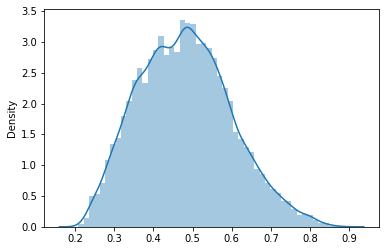

In [393]:
sns.distplot(pureg.transform(df).max(1))

membership
0    4840
1    4200
2    3909
3    3435
4    2336
5    1920
Name: y, dtype: int64

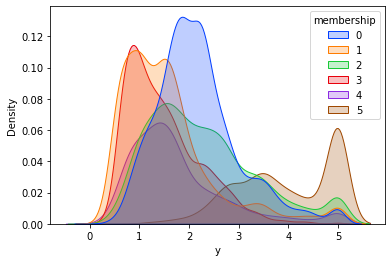

In [394]:
embs = pureg.transform(df)
point_membership = pd.DataFrame(embs.argmax(1))
msk = embs.max(1) > 0
point_membership.columns = ['membership']
point_membership['membership'] = pureg.network_embedder.labels_row_
point_membership['y'] = df[target]
point_membership['score'] = embs.max(1)

sns.kdeplot(data = point_membership[msk], x = 'y',hue = 'membership', palette = 'bright', shade = True, )
point_membership[msk].groupby('membership')['y'].count()

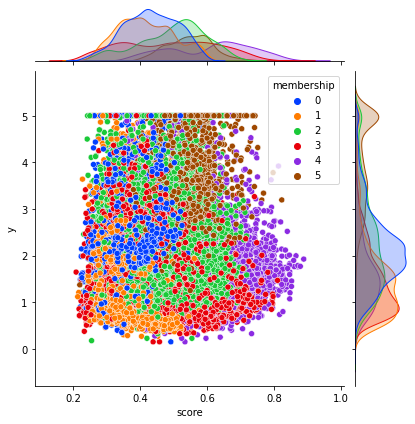

In [395]:
#sns.scatterplot(data = point_membership[msk], x = 'score', y = 'y', hue = 'membership', palette = 'bright', shade = True, )
sns.jointplot(data = point_membership[msk], x = 'score', y = 'y', hue = 'membership', palette = 'bright')

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

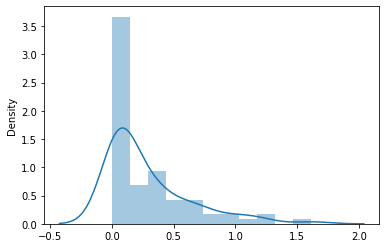

In [396]:
import seaborn as sns
sns.distplot(np.abs(pureg.linear_estimator.coef_))

In [397]:
import networkx as nx

G = nx.DiGraph()
G.add_node(0, estimator = pureg, is_root = True, is_leaf = False)

G.nodes[0]['is_root']

True

In [455]:
class _RePLAN():
    
    def __init__(
        self,
        base_partition_unit,
        max_depth = None,
        min_points_leaf = 100,        
        min_membership_score = None, #membership scores get diluted for each new level, so the sum of membership of a point accross all archetypes sum to 1
        #max_models = None, deprecated since tree is grown recursively, and druing construction, algorithm focuses on depth first
        #max_archetypes = None,
        validation_metric = None,
        validation_split = None
    ):
        '''
        Recursive structure to partition 
        
        min_points_leaf: min points in a leaf model in order to perform a new split
        depth: ammount of levels to build the tree
        min_membership_score: membership scores threshold in order to stop growing spliting further
        max_models: after reaching this ammount of models, tree growing is stoped
        max_archetypes: after reaching this ammount of archetypes, tree growing is stoped
        '''
        
        self.base_partition_unit = base_partition_unit
        self.min_points_leaf = min_points_leaf
        self.max_depth = max_depth
        self.min_membership_score = min_membership_score        
        self.validation_metric = validation_metric
        self.validation_split = validation_split
        return
    
    def _check_stopping_criteria(self, parent_name, embeddings, y, level):
        ###check global criteria
        #check depth
        if not self.max_depth is None:
            if level >= self.max_depth:
                #set all as leaf
                return np.ones(shape = (embeddings.shape[1],), dtype = bool)
        ###check parent node criteria
        ##check ML metrics
        if self.validation_metric:
            metric = self.G[parent_name][self.validation_metric]
            if metric <= self.min_validation_value:
                #set all as leaf
                return np.ones(shape = (embeddings.shape[1],), dtype = bool)
        
        ###check local (children node) criteria
                        
        ##check purity
                        
        #gather information for stopping criteria        
        return np.zeros(shape = (embeddings.shape[1],), dtype = bool)
    
    
    def fit(self, X, y = None, **kwargs):
        self.G = nx.DiGraph()
        #fit root node
        root_estim = clone(self.base_partition_unit)
        root_estim, metrics = self._fit_estim(root_estim, X=X, y=y, parent_weight = None, **kwargs)        
        #append to tree
        self.G.add_node('0', estimator = root_estim, is_root = True, is_leaf = False, **metrics)
        embs = root_estim.transform(X)                
        #fit children nodes recursively (depth first)
        self._fit_children(X, y, parent_name = '0', parent_membership_score=None, level=1)        
                
        return self
        
        
    def _fit_children(self, X, y = None, parent_name = None, parent_membership_score = None, level = 1, **kwargs):
        #get embeddings
        embeddings = self.G.nodes[parent_name]['estimator'].transform(X)
        if not parent_membership_score is None:
            embeddings = embeddings*parent_membership_score.reshape(-1,1)
        
        embs_msk = embeddings>0
        
        leaf_children_msk = self._check_stopping_criteria(parent_name=parent_name, embeddings=embeddings, y=y, level=level)
        #fit children nodes
        for i in range(len(leaf_children_msk)):
            child_name = parent_name + f'-{i}'
            is_leaf = leaf_children_msk[i]
            if is_leaf:
                self.G.add_node(child_name, estimator = None, is_root = False, is_leaf = True)
                self.G.add_edge(parent_name, child_name)

            else:
                print(embs_msk.shape)
                point_mask = embs_msk[:, i]
                Xc = X[point_mask] #X points routed to children node
                yc = y[point_mask] #y points routed to children node
                Pwc = embeddings[point_mask, i] #parent membership scores for given archetype
                Swc = kwargs['sample_weight'][point_mask] if 'sample_weight' in kwargs else None #sample_weight
                #fit children estimator
                child_estim = clone(self.base_partition_unit)
                child_estim, metrics = self._fit_estim(child_estim, X=Xc, y=yc, parent_weight=Pwc, sample_weight=Swc)
                #create children node in graph
                self.G.add_node(child_name, estimator = child_estim, is_root = False, is_leaf = False, **metrics)
                self.G.add_edge(parent_name, child_name)
                #recursive fit children
                self._fit_children(X=Xc, y=yc, parent_name=child_name, parent_membership_score = Pwc, level=level+1, **kwargs)
            
        return self
        
        
    def _fit_estim(self, estim, X, y = None, parent_weight = None, sample_weight = None):
        
        if parent_weight is None:
            parent_weight = np.ones(X.shape[0])
        if sample_weight is None:
            sample_weight = np.ones(X.shape[0])
                
        total_weight = sample_weight * parent_weight        
        
        metrics = {}
        if not self.validation_metric is None:
            #split train and validation
            #...
            #fit estimator with train set
            estim.fit(X = X, y = y, sample_weight = total_weight)            
            #calculate validation metric on holdout set
            metric_value = None
            metrics = {self.validation_metric: metric_value}
        else:
            #fit with full data
            estim.fit(X = X, y = y, sample_weight = total_weight)
        return estim, metrics
    
    def _transform_node():
        pass
    
        

In [456]:
X = df.drop(columns = target)

In [457]:
replan = _RePLAN(
    pureg,
    max_depth = 2
)

In [460]:

replan.fit(X, y)

(20640, 6)
(20640, 6)
(20640, 6)
(20640, 6)
(20640, 6)
(20640, 6)


In [459]:
replan.G.nodes

NodeView(('0', '0-0', '0-0-0', '0-0-1', '0-0-2', '0-0-3', '0-0-4', '0-0-5', '0-0-6', '0-0-7', '0-1', '0-1-0', '0-1-1', '0-1-2', '0-1-3', '0-1-4', '0-1-5', '0-1-6', '0-1-7', '0-1-8', '0-2', '0-2-0', '0-2-1', '0-2-2', '0-2-3', '0-2-4', '0-2-5', '0-2-6', '0-2-7', '0-2-8', '0-2-9', '0-3', '0-3-0', '0-3-1', '0-3-2', '0-3-3', '0-3-4', '0-3-5', '0-3-6', '0-3-7', '0-3-8', '0-3-9', '0-4', '0-4-0', '0-4-1', '0-4-2', '0-4-3', '0-4-4', '0-4-5', '0-4-6', '0-5', '0-5-0', '0-5-1', '0-5-2', '0-5-3', '0-5-4', '0-5-5', '0-5-6'))